## Follows Create_peak_by_tissue_and_Cluster

## Params and loading packages

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']


In [2]:
tss_annotation = doc['tss_annotation']

In [3]:

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Modules.Homer import *

print('Number of tissues: ',len(tissues))

('Number of tissues: ', 16)


In [4]:
meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)
meta_samples = meta_samples.set_index('Full')
meta_samples.head()


,Experiment,Short,Short_with_number,Tissue
Full,,,,
/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_peaks/merge_bg_2.peak,GRO,BMDMwt_GRO,BMDMwt_GRO1,BMDMwt
/data/isshamie/TSS/Processed/Brain/GRO/f04_peaks/merge_bg_2.peak,GRO,Brain_GRO,Brain_GRO1,Brain
/data/isshamie/TSS/Processed/Brain/mSTART/f04_peaks/merge_bg_2.peak,mSTART,Brain_mSTART,Brain_mSTART1,Brain
/data/isshamie/TSS/Processed/Heart/mSTART/f04_peaks/merge_bg_2.peak,mSTART,Heart_mSTART,Heart_mSTART1,Heart
/data/isshamie/TSS/Processed/Kidney/GRO/f04_peaks/merge_bg_2.peak,GRO,Kidney_GRO,Kidney_GRO1,Kidney


### Till Here
------


### Load in the unique TSS gff file
(Made from update_picr_info.ipynb)

In [5]:
tss = pd.read_csv(tss_annotation,sep='\t',index_col=0)

tss.head()

,Chr,Start,End,Strand,ID,Parent,gene_id,gene,transcript_id,cs,Length,actual_start
ID=asmbl_2;Parent=gene_1_2;gene_id=gene_1_2;gene=SERHL;transcript_id=asmbl_2;cs=2,picr_0,176,38694,+,asmbl_2,gene_1_2,gene_1_2,SERHL,asmbl_2,2,38518,176
ID=asmbl_4;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_4;cs=1,picr_0,7715,46630,-,asmbl_4,gene_2,gene_2,RRP7A,asmbl_4,1,38915,46630
ID=asmbl_7;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_7;cs=1,picr_0,7759,44597,-,asmbl_7,gene_2,gene_2,RRP7A,asmbl_7,1,36838,44597
ID=asmbl_8;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_8;cs=1,picr_0,7767,44597,-,asmbl_8,gene_2,gene_2,RRP7A,asmbl_8,1,36830,44597
ID=asmbl_9;Parent=gene_2;gene_id=gene_2;gene=RRP7A;transcript_id=asmbl_9;cs=1,picr_0,7789,44568,-,asmbl_9,gene_2,gene_2,RRP7A,asmbl_9,1,36779,44568


### Load peak_tissue_matrix and the annotate peaks

In [6]:
peak_tissue_matrix = pd.read_csv('Results/merged/peaks_tissues.csv',index_col=0)

In [5]:
anno_peaks = pd.read_csv('Results/merged/all_peaks_merged_anno.tsv',sep='\t',index_col=0)
anno_peaks.dropna(axis=1,how='all',inplace=True)
anno_peaks = anno_peaks.fillna('')


### Adding info to peaks
### Create additional column with the nearest TSS , gene and gene_id
#### Also determine a) average distance between start sites b) scatter plot of top 2 highest, if only one, color that one but just duplicate it


In [8]:
%%time
anno_peaks['Nearest TSS'] = ''
anno_peaks['Distance to TSS'] = np.infty
anno_peaks['isSameStrand'] = False

for ind,val in (anno_peaks.iterrows()):
    filt = tss[val['Chr'] == tss['Chr']]
    peak_start = (val['Start']+val['End'])/2
    if len(filt) != 0:
        filt2 = np.abs(filt['actual_start'] - peak_start).argmin()
        anno_peaks.set_value(ind,'Nearest TSS',tss.loc[filt2,'transcript_id'])
        
        anno_peaks.set_value(ind,'Nearest gene',tss.loc[filt2,'gene'])
        anno_peaks.set_value(ind,'Nearest gene_id',tss.loc[filt2,'gene_id'])
        
        ## Get distance to nearest gene. If on - strand, tss 'End' is the beginning
        if tss.loc[filt2,'Strand'] == '+':
            anno_peaks.set_value(ind,'Distance to TSS',peak_start - tss.loc[filt2,'actual_start'])
        elif tss.loc[filt2,'Strand'] == '-':
            anno_peaks.set_value(ind,'Distance to TSS', tss.loc[filt2,'actual_start']-peak_start)
        else:
            print 'No chr??'
        
        anno_peaks.set_value(ind,'isSameStrand',val['Strand'] == tss.loc[filt2,'Strand'])


anno_peaks.to_csv('Results/peaks_with_tss_and_gene.tsv',sep='\t')

CPU times: user 37min 38s, sys: 1.37 s, total: 37min 39s
Wall time: 37min 39s


In [9]:
print('gene id:', len(anno_peaks.groupby('Nearest gene_id')))
print('gene:',len(anno_peaks.groupby('Nearest gene')))
print('TSS:',len(anno_peaks.groupby('Nearest TSS')))

('gene id:', 21432)
('gene:', 16595)
('TSS:', 38011)


## How many peaks for a specific gene or isoform? 

In [7]:
anno_peaks = pd.read_csv('Results/peaks_with_tss_and_gene.tsv',sep='\t',index_col=0)

In [8]:
anno_peaks.head()

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Distance to TSS,Nearest PromoterID,Nearest TSS,isSameStrand,Nearest gene,Nearest gene_id
PeakID (cmd=annotatePeaks.pl Results/merged/all_peaks_merged.tsv /data/isshamie/genome/picr.fa -gff /data/isshamie/genome/updated_final_sort.gff3),,,,,,,,,,,,,
Merged-picr_48-1084706-14,picr_48,1084630,1084782,+,50717.441406,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,TTS (ID=asmbl_56918.exon2;Parent=asmbl_56918;g...,127017.0,ID=asmbl_56919.exon2;Parent=asmbl_56919;gene_i...,asmbl_56916,True,MTHFD1L,gene_20259_1
Merged-picr_33-4827737-11,picr_33,4827637,4827815,+,17077.398438,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_45526.exon1;Parent=asmb...,4.0,ID=asmbl_45526.exon1;Parent=asmbl_45526;gene_i...,asmbl_45526,True,CPA2,gene_16120
Merged-picr_13-30535388-7,picr_13,30535313,30535463,+,15631.878906,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,promoter-TSS (ID=asmbl_16617.exon1;Parent=asmb...,-267.0,ID=asmbl_16613.exon1;Parent=asmbl_16613;gene_i...,asmbl_16611,False,PARP16,gene_5744
Merged-picr_64-11363665-15,picr_64,11363590,11363741,+,8920.436523,/data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...,Intergenic,-42355.0,ID=asmbl_69800.exon2;Parent=asmbl_69800;gene_i...,asmbl_69802,True,GRM3,gene_24621
Merged-picr_16-22007181-6,picr_16,22007101,22007263,+,6541.673828,/data/isshamie/TSS/Processed/Brain/mSTART/f04_...,promoter-TSS (ID=asmbl_24868.exon3;Parent=asmb...,-25868.0,ID=asmbl_24866.exon2;Parent=asmbl_24866;gene_i...,asmbl_24876,True,DSCAML1,gene_8431


In [9]:
def get_peaks_within_distance(peaks,distance=[-1000,+100]):
    
    filt = peaks[(peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1])]
    return filt


def get_genes_peaks(peaks,gene,distance=[-1000,+100]):
    
    filt = peaks[(peaks['Nearest gene'] == gene) & 
                 ((peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1]))]
    return filt

def get_gene_ids_peaks(peaks,gene,distance=[-1000,+100]):
    
    filt = peaks[(peaks['Nearest gene_id'] == gene) & 
                 ((peaks['Distance to TSS'] > distance[0]) & (peaks['Distance to TSS'] < distance[1]))]
    return filt

def get_nearest_tss(peaks_gene): 
    #peaks of one gene
    peaks_gene['abs'] = np.abs(peaks_gene['Distance to TSS'])
    idx = peaks_gene['abs'].idxmin()
    return idx, peaks_gene.loc[idx,'Distance to TSS']


def tss_per_gene(peaks_gene): 
    #peaks of one gene
    return len(set(peaks_gene['Nearest TSS']))


def tissues_gene_expressed(peaks_gene,peaks_tissue_matrix):
    #peaks of one gene
    curr_gene_vals = peaks_tissue_matrix[peaks_tissue_matrix.isin(peaks_gene.idnex)]
    tiss = (curr_gene_vals > 1).any(axis=1)
    tiss = tiss.columns[tiss]
    return tiss

### DataFrames with either transcript, gene, or gene_id centric df

In [10]:
def create_anno_centric_df(anno_df,tss_df,peak_bin=[-1000,100],anno_col='Nearest TSS',tss_df_col='transcript_id',f_save='txn_df'):
    gene_list = tss_df[tss_df_col].unique()
    
    prom_col1 = 'bin_%d_%d' % (peak_bin[0],peak_bin[1]) #This column is for + and - strands within the bin range
    prom_col2 = 'tss_bin_%d_%d' % (peak_bin[0],peak_bin[1])   #This column is only for the same strand
    
    df = pd.DataFrame(index=gene_list,columns=['peaks','Closest_to_X_numberOfPeaks',prom_col1,prom_col2,
                                                    'tissues','minDistance','minDistancePeak',
                                                    'maxValue','maxPeakId','maxTissues',
                                                    'Chr','Start','End','Strand'
                                                    'gene_id','gene','transcript'])                                                 
                            
    df['Closest_to_X_numberOfPeaks'] = 0
    df['peaks'] = [[]] * len(df)
    df['minDistance'] = np.infty
    df['tissues'] = [[]] * len(df)
    df['maxTissues'] = [[]] * len(df)
    df[prom_col1] = [[]] * len(df)
    df[prom_col2] = [[]] * len(df)

    for i in tqdm.tqdm_notebook(anno_df.groupby([anno_col])):
        curr_gene = i[0]
        df.loc[curr_gene,'Closest_to_X_numberOfPeaks'] += len(i[1])
        curr = i[1]
        df.at[curr_gene,'peaks'] = list(curr.index)

        ## Filter to only within the distance of -1kb to +100bp
        #curr = get_genes_peaks(curr,curr_gene,distance=[-1000,+100])
        curr = get_peaks_within_distance(curr,distance=peak_bin)

        df.at[curr_gene,prom_col1]=list(curr.index)

        ## Filter to only peaks with isSameStrand 
        curr = curr[curr['isSameStrand'] == True]
        df.at[curr_gene,prom_col2] = list(curr.index)

        ## Find closest peak
        if len(curr) == 0:
            continue
        if isinstance(curr,pd.Series):
            print('is a series', curr)

        minPeak, minPeakValue = get_nearest_tss(curr)
        df.at[curr_gene,'minDistance'] = minPeakValue
        df.at[curr_gene,'minDistancePeak'] = minPeak

        ## Store which tissues that have a peak 
        ## Try statement b/c few peaks were not in the expression matrix for some reason
        try: 
            curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[curr.index]>0).any()].values
            curr_tss_df_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(curr.index)]
            curr_tissues = list(meta_samples.loc[curr_tissues,'Short'])
            df.at[curr_gene,'tissues'] = curr_tissues
            if 'CHO' in curr_tissues:
                df.at[curr_gene,'is_in_cho_promoter'] = True

            ## Get the peak that had the highest Count per million
            max_peak = curr_tss_df_peaks.max(axis=1).idxmax()
            max_value = curr_tss_df_peaks.max(axis=1).max()
            df.at[curr_gene,'maxValue'] = max_value
            df.at[curr_gene,'maxPeakId'] = max_peak
            ## Tissues that had the maxPeak
            curr_tissues = peak_tissue_matrix.columns[(peak_tissue_matrix.loc[max_peak]>0)].values
            curr_tissues = list(meta_samples.loc[curr_tissues,'Short'])
            df.at[curr_gene,'maxTissues'] = curr_tissues


            ## Get peak info for max peak
            start = curr.loc[max_peak,'Start']
            end = curr.loc[max_peak,'End']
            chrom = curr.loc[max_peak,'Chr']
            strand = curr.loc[max_peak,'Strand']
            gene = curr.loc[max_peak,'Nearest gene']
            gene_id = curr.loc[max_peak,'Nearest gene_id']
            mrna = curr.loc[max_peak,'Nearest TSS']
            ## Assigning values
            df.at[curr_gene,'transcript'] = mrna
            df.at[curr_gene,'gene'] = gene
            df.at[curr_gene,'gene_id'] = gene_id
            df.at[curr_gene,'Start'] = start
            df.at[curr_gene,'End'] = end
            df.at[curr_gene,'Chr'] = chrom
            df.at[curr_gene,'Strand'] = strand
           
        except KeyError :
            print curr.index + ' not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'

    df['hasGene'] = df.fillna('')[prom_col2].apply(lambda x: len(x) > 0)
    df['Number of SS'] = df[prom_col2].fillna('').apply(lambda x: len(x))

    df.to_csv('Results/' + f_save + '.csv')
    df.to_pickle('Results/' + f_save + '.p')
    
    print('Total Number : ', len(df))
    print('Total Number with start sites: ',np.sum(df['hasGene']))
    print('Fraction with start sites: ',1.0*np.sum(df['hasGene'])/len(df))
    return df



In [11]:
%%time
create_anno_centric_df(
    anno_peaks,
    tss,
    anno_col='Nearest gene',
    tss_df_col='gene',
    f_save='gene_df')

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Index([u'Merged-picr_122-560705-1-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')

('Total Number : ', 17246)
('Total Number with start sites: ', 11555)
('Fraction with start sites: ', 0.6700104372028296)
CPU times: user 19min 49s, sys: 9.93 s, total: 19min 59s
Wall time: 19min 51s


,peaks,Closest_to_X_numberOfPeaks,bin_-1000_100,tss_bin_-1000_100,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,Strandgene_id,gene,transcript,gene_id,Strand,hasGene,Number of SS
SERHL,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...",10,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31.000000,Merged-picr_0-20959-16,1666.35,Merged-picr_74-10067746-3,"[Heart_mSTART, Kidney_GRO, Kidney_mSTART]",picr_74,10067654,10067857,NaN,SERHL,asmbl_75212,gene_26628_1,+,True,2
RRP7A,"[Merged-picr_10-20507337-4, Merged-picr_0-4463...",26,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4]",[Merged-picr_0-44487-4],"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26.000000,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,NaN,RRP7A,asmbl_10,gene_2,-,True,1
POLDIP3,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...",38,"[Merged-picr_0-78615-14, Merged-picr_0-98958-1...",[Merged-picr_0-78299-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",-41.000000,Merged-picr_0-78299-12,34.8,Merged-picr_0-78299-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,78177,78416,NaN,POLDIP3,asmbl_19,gene_3_1,-,True,1
CYB5R3,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",16,"[Merged-picr_0-92870-1, Merged-picr_0-92200-1,...","[Merged-picr_0-92200-1, Merged-picr_0-92664-2]","[BMDMwt_GRO, CHO_mSTART]",0.000000,Merged-picr_0-92200-1,4.51,Merged-picr_0-92200-1,[BMDMwt_GRO],picr_0,92125,92275,NaN,CYB5R3,asmbl_20,gene_3_2,-,True,2
A4GALT,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...",31,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...","[Merged-picr_0-185727-8, Merged-picr_0-186292-5]","[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",5.000000,Merged-picr_0-186292-5,30.75,Merged-picr_0-185727-8,"[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",picr_0,185649,185806,NaN,A4GALT,asmbl_30,gene_4_3,-,True,2
ARFGAP3,"[Merged-picr_0-298206-10, Merged-picr_0-275657...",23,"[Merged-picr_0-298206-10, Merged-picr_0-275792...",[Merged-picr_0-298206-10],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",29.000000,Merged-picr_0-298206-10,307.9,Merged-picr_0-298206-10,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",picr_0,298116,298309,NaN,ARFGAP3,asmbl_31,gene_5_1,-,True,1
PACSIN2,"[Merged-picr_0-398822-16, Merged-picr_0-399078...",58,"[Merged-picr_0-398822-16, Merged-picr_0-399078...","[Merged-picr_0-398822-16, Merged-picr_0-364379...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",24.000000,Merged-picr_0-364379-11,1197.35,Merged-picr_0-398822-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,398728,398918,NaN,PACSIN2,asmbl_43,gene_6,-,True,2
TTLL1,"[Merged-picr_0-440919-12, Merged-picr_0-441054...",5,"[Merged-picr_0-440919-12, Merged-picr_0-441054-4]",[Merged-picr_0-440919-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",25.000000,Merged-picr_0-440919-12,158.3,Merged-picr_0-440919-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,440836,440998,NaN,TTLL1,asmbl_49,gene_7,-,True,1
BIK,"[Merged-picr_0-470591-1, Merged-picr_0-457769-...",15,"[Merged-picr_0-470591-1, Merged-picr_0-456863-...","[Merged-picr_0-470591-1, Merged-picr_0-456863-...","[Liver_GRO, CHO_mSTART]",-9.000000,Merged-picr_0-470591-1,19.5,Merged-picr_0-470591-1,[CHO_mSTART],picr_0,470516,470666,NaN,BIK,asmbl_63,gene_11,+,True,3
MCAT,"[Merged-picr_0-491595-9, Merged-picr_0-492294-...",10,"[Merged-picr_0-491595-9, Merged-picr_0-492294-...","[Merged-picr_0-491493-6, Merged-picr_0-492444-5]","[BMDMwt_GRO, Brain_GRO, Kidney_GRO, Lung_GRO, ...",23.000000,Merged-picr_0-491493-6,12.45,Merged-picr_0-491493-6,"[BMDMwt_GRO, Brain_GRO, Lung_GRO, Spleen_GRO, ...",picr_0,491388,491602,NaN,MCAT,asmbl_57,gene_10,-,True,2


In [12]:
%%time
create_anno_centric_df(
    anno_peaks,
    tss,
    anno_col='Nearest TSS',
    tss_df_col='transcript_id',
    f_save='txn_df')

Index([u'Merged-picr_122-560705-1-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



('Total Number : ', 52382)
('Total Number with start sites: ', 17440)
('Fraction with start sites: ', 0.33293879576953916)
CPU times: user 29min 40s, sys: 6.78 s, total: 29min 47s
Wall time: 29min 41s


,peaks,Closest_to_X_numberOfPeaks,bin_-1000_100,tss_bin_-1000_100,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,Strandgene_id,gene,transcript,gene_id,Strand,hasGene,Number of SS
asmbl_2,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_4,"[Merged-picr_0-45924-1, Merged-picr_0-50486-1,...",3,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_7,[Merged-picr_0-44638-7],1,[Merged-picr_0-44638-7],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_8,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_9,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_10,"[Merged-picr_0-44487-4, Merged-picr_0-44249-1,...",4,[Merged-picr_0-44487-4],[Merged-picr_0-44487-4],"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26.000000,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,NaN,RRP7A,asmbl_10,gene_2,-,True,1
asmbl_11,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_12,[Merged-picr_0-20806-9],1,[Merged-picr_0-20806-9],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_14,[Merged-picr_0-20959-16],1,[Merged-picr_0-20959-16],[Merged-picr_0-20959-16],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31.000000,Merged-picr_0-20959-16,96.55,Merged-picr_0-20959-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,20879,21067,NaN,SERHL,asmbl_14,gene_1_4,+,True,1
asmbl_15,[Merged-picr_0-27692-1],1,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0


In [13]:
%%time
create_anno_centric_df(
    anno_peaks,
    tss,
    anno_col='Nearest gene_id',
    tss_df_col='gene_id',
    f_save='gene_id_df')

/home/isshamie/software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:50: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Index([u'Merged-picr_122-560705-1-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')

('Total Number : ', 24562)
('Total Number with start sites: ', 12761)
('Fraction with start sites: ', 0.5195423825421382)
CPU times: user 36min 54s, sys: 8.17 s, total: 37min 2s
Wall time: 36min 54s


,peaks,Closest_to_X_numberOfPeaks,bin_-1000_100,tss_bin_-1000_100,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,Strandgene_id,gene,transcript,gene_id,Strand,hasGene,Number of SS
gene_1_2,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
gene_2,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4,...",8,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4]",[Merged-picr_0-44487-4],"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26.000000,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,NaN,RRP7A,asmbl_10,gene_2,-,True,1
gene_1_4,"[Merged-picr_0-20959-16, Merged-picr_0-20806-9...",3,"[Merged-picr_0-20959-16, Merged-picr_0-20806-9]",[Merged-picr_0-20959-16],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31.000000,Merged-picr_0-20959-16,96.55,Merged-picr_0-20959-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,20879,21067,NaN,SERHL,asmbl_14,gene_1_4,+,True,1
gene_3_1,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...",38,"[Merged-picr_0-78615-14, Merged-picr_0-98958-1...",[Merged-picr_0-78299-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",-41.000000,Merged-picr_0-78299-12,34.8,Merged-picr_0-78299-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,78177,78416,NaN,POLDIP3,asmbl_19,gene_3_1,-,True,1
gene_3_2,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",16,"[Merged-picr_0-92870-1, Merged-picr_0-92200-1,...","[Merged-picr_0-92200-1, Merged-picr_0-92664-2]","[BMDMwt_GRO, CHO_mSTART]",0.000000,Merged-picr_0-92200-1,4.51,Merged-picr_0-92200-1,[BMDMwt_GRO],picr_0,92125,92275,NaN,CYB5R3,asmbl_20,gene_3_2,-,True,2
gene_4_1,[],0,[],[],[],inf,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0
gene_4_3,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...",31,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...","[Merged-picr_0-185727-8, Merged-picr_0-186292-5]","[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",5.000000,Merged-picr_0-186292-5,30.75,Merged-picr_0-185727-8,"[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",picr_0,185649,185806,NaN,A4GALT,asmbl_30,gene_4_3,-,True,2
gene_5_1,"[Merged-picr_0-298206-10, Merged-picr_0-275657...",23,"[Merged-picr_0-298206-10, Merged-picr_0-275792...",[Merged-picr_0-298206-10],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",29.000000,Merged-picr_0-298206-10,307.9,Merged-picr_0-298206-10,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",picr_0,298116,298309,NaN,ARFGAP3,asmbl_31,gene_5_1,-,True,1
gene_6,"[Merged-picr_0-398822-16, Merged-picr_0-399078...",58,"[Merged-picr_0-398822-16, Merged-picr_0-399078...","[Merged-picr_0-398822-16, Merged-picr_0-364379...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",24.000000,Merged-picr_0-364379-11,1197.35,Merged-picr_0-398822-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,398728,398918,NaN,PACSIN2,asmbl_43,gene_6,-,True,2
gene_7,"[Merged-picr_0-440919-12, Merged-picr_0-441054...",5,"[Merged-picr_0-440919-12, Merged-picr_0-441054-4]",[Merged-picr_0-440919-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",25.000000,Merged-picr_0-440919-12,158.3,Merged-picr_0-440919-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,440836,440998,NaN,TTLL1,asmbl_49,gene_7,-,True,1


### Same, but with peaks allowed to be w/in 1kb to be considered part of the annotation

In [11]:
%%time

## More liberal promoter calling -1kb:+1kb
create_anno_centric_df(
    anno_peaks,
    tss,
    peak_bin=[-1000, 1000],
    anno_col='Nearest gene',
    tss_df_col='gene',
    f_save='gene_df_1kb_1kb')

Index([u'Merged-picr_122-560705-1-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')

('Total Number : ', 17246)
('Total Number with start sites: ', 14020)
('Fraction with start sites: ', 0.8129421315087556)
CPU times: user 21min 12s, sys: 8.27 s, total: 21min 21s
Wall time: 21min 12s


,peaks,numberOfPeaks,bin_-1000_1000,tss_bin_-1000_1000,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
SERHL,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...",10,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31.000000,Merged-picr_0-20959-16,1666.35,Merged-picr_74-10067746-3,"[Heart_mSTART, Kidney_GRO, Kidney_mSTART]",picr_74,10067654,10067857,gene_26628_1,SERHL,asmbl_75212,True,2
RRP7A,"[Merged-picr_10-20507337-4, Merged-picr_0-4463...",26,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4,...","[Merged-picr_0-44487-4, Merged-picr_0-45924-1]","[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26.000000,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,gene_2,RRP7A,asmbl_10,True,2
POLDIP3,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...",38,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...","[Merged-picr_0-98815-14, Merged-picr_0-78299-1...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",-41.000000,Merged-picr_0-78299-12,146.4,Merged-picr_0-98815-14,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,98719,98916,gene_3_1,POLDIP3,asmbl_17,True,4
CYB5R3,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",16,"[Merged-picr_0-92870-1, Merged-picr_0-92200-1,...","[Merged-picr_0-92200-1, Merged-picr_0-91209-1,...","[BMDMwt_GRO, Spleen_GRO, CHO_mSTART]",0.000000,Merged-picr_0-92200-1,4.51,Merged-picr_0-92200-1,[BMDMwt_GRO],picr_0,92125,92275,gene_3_2,CYB5R3,asmbl_20,True,3
A4GALT,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...",31,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...","[Merged-picr_0-185727-8, Merged-picr_0-186292-...","[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",5.000000,Merged-picr_0-186292-5,30.75,Merged-picr_0-185727-8,"[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",picr_0,185649,185806,gene_4_3,A4GALT,asmbl_30,True,3
ARFGAP3,"[Merged-picr_0-298206-10, Merged-picr_0-275657...",23,"[Merged-picr_0-298206-10, Merged-picr_0-275657...","[Merged-picr_0-298206-10, Merged-picr_0-275657...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",29.000000,Merged-picr_0-298206-10,307.9,Merged-picr_0-298206-10,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",picr_0,298116,298309,gene_5_1,ARFGAP3,asmbl_31,True,3
PACSIN2,"[Merged-picr_0-398822-16, Merged-picr_0-399078...",58,"[Merged-picr_0-398822-16, Merged-picr_0-399078...","[Merged-picr_0-398822-16, Merged-picr_0-364379...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",24.000000,Merged-picr_0-364379-11,1197.35,Merged-picr_0-398822-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,398728,398918,gene_6,PACSIN2,asmbl_43,True,3
TTLL1,"[Merged-picr_0-440919-12, Merged-picr_0-441054...",5,"[Merged-picr_0-440919-12, Merged-picr_0-441054-4]",[Merged-picr_0-440919-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",25.000000,Merged-picr_0-440919-12,158.3,Merged-picr_0-440919-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,440836,440998,gene_7,TTLL1,asmbl_49,True,1
BIK,"[Merged-picr_0-470591-1, Merged-picr_0-457769-...",15,"[Merged-picr_0-470591-1, Merged-picr_0-457769-...","[Merged-picr_0-470591-1, Merged-picr_0-457907-...","[BMDMwt_GRO, Liver_GRO, Lung_GRO, CHO_mSTART]",-9.000000,Merged-picr_0-470591-1,19.5,Merged-picr_0-470591-1,[CHO_mSTART],picr_0,470516,470666,gene_11,BIK,asmbl_63,True,4
MCAT,"[Merged-picr_0-491595-9, Merged-picr_0-492294-...",10,"[Merged-picr_0-491595-9, Merged-picr_0-492294-...","[Merged-picr_0-491493-6, Merged-picr_0-492444-5]","[BMDMwt_GRO, Brain_GRO, Kidney_GRO, Lung_GRO, ...",23.000000,Merged-picr_0-491493-6,12.45,Merged-picr_0-491493-6,"[BMDMwt_GRO, Brain_GRO, Lung_GRO, Spleen_GRO, ...",picr_0,491388,491602,gene_10,MCAT,asmbl_57,True,2


In [ ]:
%%time

create_anno_centric_df(
    anno_peaks,
    tss,
    peak_bin=[-1000, 1000],
    anno_col='Nearest TSS',
    tss_df_col='transcript_id',
    f_save='txn_df_1kb_1kb')

Index([u'Merged-picr_122-560705-1-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')

('Total Number : ', 52382)
('Total Number with start sites: ', 23164)
('Fraction with start sites: ', 0.4422129739223397)
CPU times: user 43min 30s, sys: 8.32 s, total: 43min 39s
Wall time: 43min 31s


,peaks,numberOfPeaks,bin_-1000_1000,tss_bin_-1000_1000,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
asmbl_2,,0,NaN,NaN,,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_4,"[Merged-picr_0-45924-1, Merged-picr_0-50486-1,...",3,[Merged-picr_0-45924-1],[Merged-picr_0-45924-1],[CHO_mSTART],706.000000,Merged-picr_0-45924-1,3.04,Merged-picr_0-45924-1,[CHO_mSTART],picr_0,45849,45999,gene_2,RRP7A,asmbl_4,True,1
asmbl_7,[Merged-picr_0-44638-7],1,[Merged-picr_0-44638-7],[],,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_8,,0,NaN,NaN,,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_9,,0,NaN,NaN,,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_10,"[Merged-picr_0-44487-4, Merged-picr_0-44249-1,...",4,"[Merged-picr_0-44487-4, Merged-picr_0-44249-1,...",[Merged-picr_0-44487-4],"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26.000000,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,gene_2,RRP7A,asmbl_10,True,1
asmbl_11,,0,NaN,NaN,,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_12,[Merged-picr_0-20806-9],1,[Merged-picr_0-20806-9],[],,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
asmbl_14,[Merged-picr_0-20959-16],1,[Merged-picr_0-20959-16],[Merged-picr_0-20959-16],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31.000000,Merged-picr_0-20959-16,96.55,Merged-picr_0-20959-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,20879,21067,gene_1_4,SERHL,asmbl_14,True,1
asmbl_15,[Merged-picr_0-27692-1],1,[],[],,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0


In [ ]:
%%time
create_anno_centric_df(
    anno_peaks,
    tss,
    peak_bin=[-1000, 1000],
    anno_col='Nearest gene_id',
    tss_df_col='gene_id',
    f_save='gene_id_df_1kb_1kb')

Index([u'Merged-picr_122-560705-1-2 not in peak expression file. Maybe it was dropped from being a duplicate? Or no peak had a value in it.'], dtype='object')

('Total Number : ', 24562)
('Total Number with start sites: ', 15698)
('Fraction with start sites: ', 0.6391173357218467)
CPU times: user 46min 11s, sys: 10.3 s, total: 46min 22s
Wall time: 46min 11s


,peaks,numberOfPeaks,bin_-1000_1000,tss_bin_-1000_1000,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
gene_1_2,,0,NaN,NaN,,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
gene_2,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4,...",8,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4,...","[Merged-picr_0-44487-4, Merged-picr_0-45924-1]","[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26.000000,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,gene_2,RRP7A,asmbl_10,True,2
gene_1_4,"[Merged-picr_0-20959-16, Merged-picr_0-20806-9...",3,"[Merged-picr_0-20959-16, Merged-picr_0-20806-9]",[Merged-picr_0-20959-16],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31.000000,Merged-picr_0-20959-16,96.55,Merged-picr_0-20959-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,20879,21067,gene_1_4,SERHL,asmbl_14,True,1
gene_3_1,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...",38,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...","[Merged-picr_0-98815-14, Merged-picr_0-78299-1...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",-41.000000,Merged-picr_0-78299-12,146.4,Merged-picr_0-98815-14,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,98719,98916,gene_3_1,POLDIP3,asmbl_17,True,4
gene_3_2,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",16,"[Merged-picr_0-92870-1, Merged-picr_0-92200-1,...","[Merged-picr_0-92200-1, Merged-picr_0-91209-1,...","[BMDMwt_GRO, Spleen_GRO, CHO_mSTART]",0.000000,Merged-picr_0-92200-1,4.51,Merged-picr_0-92200-1,[BMDMwt_GRO],picr_0,92125,92275,gene_3_2,CYB5R3,asmbl_20,True,3
gene_4_1,,0,NaN,NaN,,inf,,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,False,0
gene_4_3,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...",31,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...","[Merged-picr_0-185727-8, Merged-picr_0-186292-...","[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",5.000000,Merged-picr_0-186292-5,30.75,Merged-picr_0-185727-8,"[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",picr_0,185649,185806,gene_4_3,A4GALT,asmbl_30,True,3
gene_5_1,"[Merged-picr_0-298206-10, Merged-picr_0-275657...",23,"[Merged-picr_0-298206-10, Merged-picr_0-275657...","[Merged-picr_0-298206-10, Merged-picr_0-275657...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",29.000000,Merged-picr_0-298206-10,307.9,Merged-picr_0-298206-10,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Kidney_G...",picr_0,298116,298309,gene_5_1,ARFGAP3,asmbl_31,True,3
gene_6,"[Merged-picr_0-398822-16, Merged-picr_0-399078...",58,"[Merged-picr_0-398822-16, Merged-picr_0-399078...","[Merged-picr_0-398822-16, Merged-picr_0-364379...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",24.000000,Merged-picr_0-364379-11,1197.35,Merged-picr_0-398822-16,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,398728,398918,gene_6,PACSIN2,asmbl_43,True,3
gene_7,"[Merged-picr_0-440919-12, Merged-picr_0-441054...",5,"[Merged-picr_0-440919-12, Merged-picr_0-441054-4]",[Merged-picr_0-440919-12],"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",25.000000,Merged-picr_0-440919-12,158.3,Merged-picr_0-440919-12,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,440836,440998,gene_7,TTLL1,asmbl_49,True,1


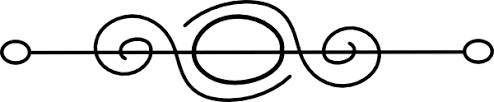

In [16]:
from IPython.display import Image
Image(filename='/home/isshamie/chapter_break.png')

## Create bed file of tss

### Load

In [14]:
txn_df = pickle.load(open('Results/txn_df.p','rb'))
gene_df = pickle.load(open('Results/gene_df.p','rb'))
gene_id_df = pickle.load(open('Results/gene_id_df.p','rb'))


print('Percent of isoforms identified: ', 1.0*np.sum(txn_df['hasGene'])/txn_df.shape[0])
print('Percent of genes identified: ', 1.0*np.sum(gene_df['hasGene'])/gene_df.shape[0])

txn_hasTSS = txn_df[txn_df['hasGene']]
txn_hasTSS = txn_hasTSS[~(txn_hasTSS.isnull().any(axis=1))]

## Putting into bed format
tss_peakCenter_bed = pd.DataFrame()
for ind,val in txn_hasTSS.iterrows():
    cs = tss[tss['transcript_id'] == ind]['cs'].values[0]
    title = '%s;%s;%s;%s;cs=%d' % (val['gene'],val['gene_id'],ind,','.join(val['tissues']),cs)

    
    strand = tss[tss['transcript_id'] == ind]['Strand'].values[0]
    
    tss_peakCenter_bed = tss_peakCenter_bed.append({'chrom':val['Chr'], 
                                'chromStart': val['Start'],
                                'chromEnd':val['End'],
                                'name':title,
                                'score': val['maxValue'],
                                'strand':strand},ignore_index=True)

    
tss_peakCenter_bed = tss_peakCenter_bed[['chrom','chromStart','chromEnd','name','score','strand']]
tss_peakCenter_bed['chromStart'] = tss_peakCenter_bed['chromStart'].astype(int)
tss_peakCenter_bed['chromEnd'] = tss_peakCenter_bed['chromEnd'].astype(int)

In [20]:
tss_peakCenter_bed

,chrom,chromStart,chromEnd,name,score,strand
0,picr_0,44409,44566,"RRP7A;gene_2;asmbl_10;Brain_GRO,Brain_mSTART,S...",10.105000,-
1,picr_0,20879,21067,"SERHL;gene_1_4;asmbl_14;BMDMwt_GRO,Brain_GRO,B...",96.550003,+
2,picr_0,78177,78416,"POLDIP3;gene_3_1;asmbl_19;BMDMwt_GRO,Brain_GRO...",34.799999,-
3,picr_0,92125,92275,"CYB5R3;gene_3_2;asmbl_20;BMDMwt_GRO,CHO_mSTART...",4.510000,-
4,picr_0,186158,186419,"A4GALT;gene_4_3;asmbl_24;BMDMwt_GRO,Brain_GRO,...",9.460000,-
5,picr_0,185649,185806,"A4GALT;gene_4_3;asmbl_30;BMDMwt_GRO,Brain_GRO,...",30.750000,-
6,picr_0,298116,298309,"ARFGAP3;gene_5_1;asmbl_31;BMDMwt_GRO,Brain_GRO...",307.899994,-
7,picr_0,398728,398918,"PACSIN2;gene_6;asmbl_43;BMDMwt_GRO,Brain_GRO,B...",1197.349976,-
8,picr_0,364264,364487,"PACSIN2;gene_6;asmbl_37;BMDMwt_GRO,Brain_GRO,B...",103.199997,-
9,picr_0,440836,440998,"TTLL1;gene_7;asmbl_49;BMDMwt_GRO,Brain_GRO,Bra...",158.300003,-


### Save tss bed file 

In [22]:
os.mkdir('Results/tss_final')

In [23]:
f_save = 'Results/tss_final/tss_peakCenter'
tss_peakCenter_bed.to_csv(f_save + '.bed',sep='\t',header=None,index=None)

## Create gene-by-tissue matrix

In [39]:

def gene_df_to_TSS_expression(gene_df,peak_tissue_matrix,col_name = 'promoterPeaks'):
    ''' Create geneXpeakValue matrix where rows are genes and cols are tissues.
    For each gene, take all the peaks that match that, and for each tissue, take its max expression for each tissue
    '''
    gene_tissue_matrix = pd.DataFrame(index=gene_df.index,columns=peak_tissue_matrix.columns,dtype='float32').fillna(0)

    for ind,val in tqdm.tqdm_notebook(gene_df.iterrows()):
        if type(val[col_name]) == list:#type(val['sameSt'~np.isnan(val['promoterPeaks']):
            curr_peaks = peak_tissue_matrix[peak_tissue_matrix.index.isin(val[col_name])]
            gene_tissue_matrix.loc[ind] = curr_peaks.max()
    gene_tissue_matrix.fillna(0,inplace=True)
    return gene_tissue_matrix



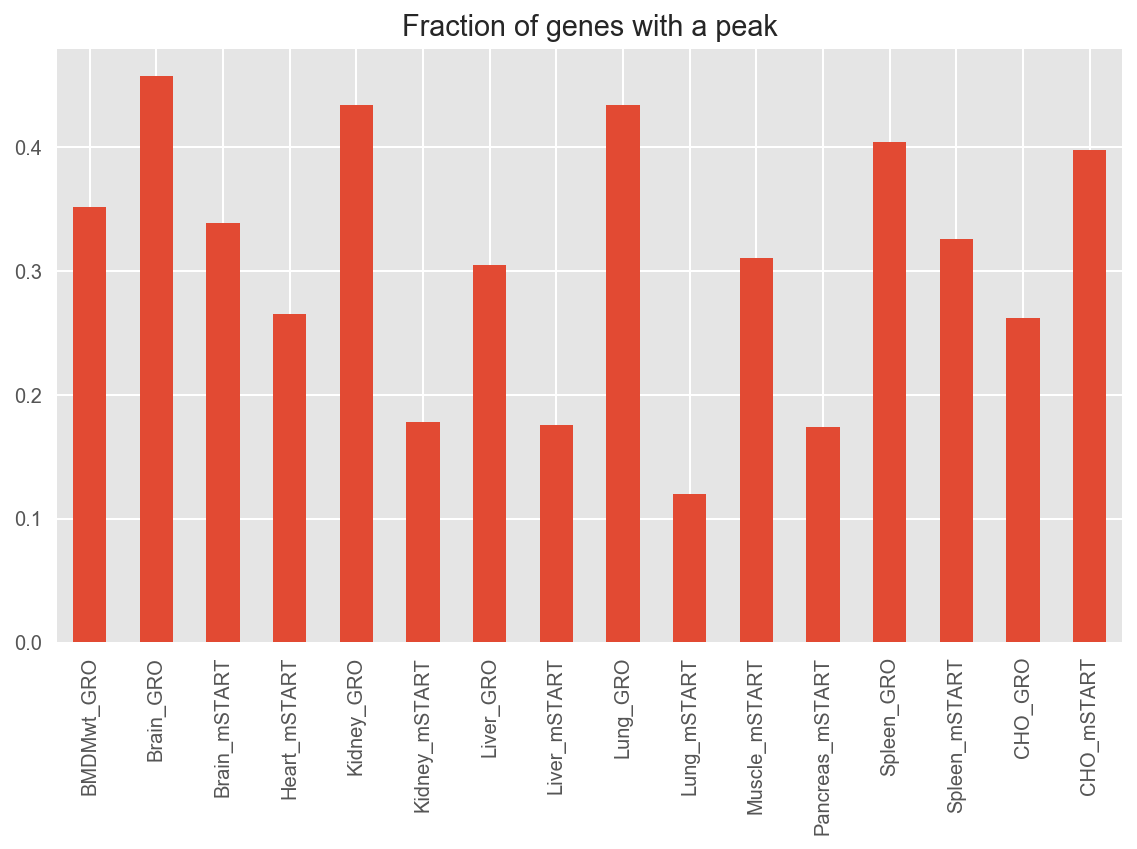

In [40]:
gene_df = pickle.load(open("Results/gene_df.p",'rb'))

gene_tissue_matrix = gene_df_to_TSS_expression(gene_df,peak_tissue_matrix)
gene_tissue_matrix.to_csv('Results/merged/genes_tissues.csv')

f = plt.figure()
ax = (np.sum((gene_tissue_matrix>0))/gene_df.shape[0]).plot.bar()
ax.set_title('Fraction of genes with a peak');
ax.set_xticklabels(meta_samples.loc[short_gene_tissue.columns,'Short']);
plt.tight_layout()
plt.savefig('Results/Figures/tissue_genes.png')

### Same, but with 1kb-1kb

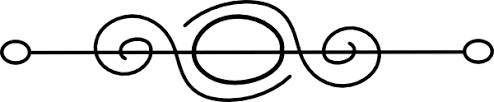

In [16]:
from IPython.display import Image
Image(filename='/home/isshamie/chapter_break.png')

In [43]:
gene_df.head()

,peaks,numberOfPeaks,bin_-1000_1000,tss_bin_-1000_1000,tissues,minDistance,minDistancePeak,maxValue,maxPeakId,maxTissues,Chr,Start,End,gene_id,gene,transcript,hasGene,Number of SS
SERHL,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...",10,"[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[Merged-picr_74-10067746-3, Merged-picr_0-2095...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",31.0,Merged-picr_0-20959-16,1666.35,Merged-picr_74-10067746-3,"[Heart_mSTART, Kidney_GRO, Kidney_mSTART]",picr_74,10067654,10067857,gene_26628_1,SERHL,asmbl_75212,True,2
RRP7A,"[Merged-picr_10-20507337-4, Merged-picr_0-4463...",26,"[Merged-picr_0-44638-7, Merged-picr_0-44487-4,...","[Merged-picr_0-44487-4, Merged-picr_0-45924-1]","[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",26.0,Merged-picr_0-44487-4,10.105,Merged-picr_0-44487-4,"[Brain_GRO, Brain_mSTART, Spleen_mSTART, CHO_m...",picr_0,44409,44566,gene_2,RRP7A,asmbl_10,True,2
POLDIP3,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...",38,"[Merged-picr_0-78615-14, Merged-picr_0-98815-1...","[Merged-picr_0-98815-14, Merged-picr_0-78299-1...","[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",-41.0,Merged-picr_0-78299-12,146.4,Merged-picr_0-98815-14,"[BMDMwt_GRO, Brain_GRO, Brain_mSTART, Heart_mS...",picr_0,98719,98916,gene_3_1,POLDIP3,asmbl_17,True,4
CYB5R3,"[Merged-picr_0-94356-1, Merged-picr_0-92870-1,...",16,"[Merged-picr_0-92870-1, Merged-picr_0-92200-1,...","[Merged-picr_0-92200-1, Merged-picr_0-91209-1,...","[BMDMwt_GRO, Spleen_GRO, CHO_mSTART]",0.0,Merged-picr_0-92200-1,4.51,Merged-picr_0-92200-1,[BMDMwt_GRO],picr_0,92125,92275,gene_3_2,CYB5R3,asmbl_20,True,3
A4GALT,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...",31,"[Merged-picr_0-185727-8, Merged-picr_0-185806-...","[Merged-picr_0-185727-8, Merged-picr_0-186292-...","[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",5.0,Merged-picr_0-186292-5,30.75,Merged-picr_0-185727-8,"[BMDMwt_GRO, Brain_GRO, Heart_mSTART, Kidney_G...",picr_0,185649,185806,gene_4_3,A4GALT,asmbl_30,True,3


In [44]:
gene_df = pickle.load(open("Results/gene_df_1kb_1kb.p",'rb'))

gene_tissue_matrix = gene_df_to_TSS_expression(gene_df,peak_tissue_matrix,col_name='tss_bin_-1000_1000')
gene_tissue_matrix.to_csv('Results/merged/genes_tissues_1kb_1kb.csv')
